In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [43]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-05 19:03:04.849686: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-05 19:03:05.801816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 19:03:05.802784: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-05 19:03:06.319549: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 19:03:06.322059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13327, 512, 512, 1) (13327, 512, 512, 1) (3439, 512, 512, 1) (3439, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13327, 512, 512, 1) (3439, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(568, 512, 512, 1) (568, 512, 512, 1) (568, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((133, 512, 512, 1), (133, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-05 19:06:17.541606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 19:06:17.544492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:90:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 19:06:17.554299: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-05 19:06:17.557318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-05 19:06:17.559693: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-05 19:06:18.541506: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-05 19:06:18.562767: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-05 19:06:19.886079: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-05 19:06:20.577004: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-05 19:06:21.324396: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-05 19:06:21.324418: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-05 19:06:21.324480: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-05 19:06:21.418232: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-05 19:06:22.236896: I tensorflow/stream_exec

13/13 [==============================] - 38s 1s/step - loss: 0.8735 - iou: 9.2030e-05 - iou_thresholded: 7.8080e-04 - val_loss: 0.1954 - val_iou: 3.8083e-06 - val_iou_thresholded: 0.0034
Epoch 2/200
13/13 [==============================] - 26s 1s/step - loss: 0.0310 - iou: 3.4635e-04 - iou_thresholded: 8.4581e-04 - val_loss: 0.0040 - val_iou: 1.9067e-04 - val_iou_thresholded: 0.0034
Epoch 3/200
13/13 [==============================] - 13s 986ms/step - loss: 0.0022 - iou: 2.5666e-04 - iou_thresholded: 9.0273e-04 - val_loss: 0.0015 - val_iou: 0.0047 - val_iou_thresholded: 0.0034
Epoch 4/200
13/13 [==============================] - 13s 989ms/step - loss: 0.0011 - iou: 0.0055 - iou_thresholded: 9.5236e-04 - val_loss: 0.0010 - val_iou: 0.0271 - val_iou_thresholded: 0.0034
Epoch 5/200
13/13 [==============================] - 13s 989ms/step - loss: 8.7566e-04 - iou: 0.0150 - iou_thresholded: 8.7228e-04 - val_loss: 9.6026e-04 - val_iou: 0.0300 - val_iou_thresholded: 0.0034
Epoch 6/200
13/13 [=

13/13 [==============================] - 13s 989ms/step - loss: 3.8556e-04 - iou: 0.2577 - iou_thresholded: 0.3558 - val_loss: 8.5352e-04 - val_iou: 0.1847 - val_iou_thresholded: 0.1711
Epoch 43/200
13/13 [==============================] - 13s 1s/step - loss: 4.0163e-04 - iou: 0.2412 - iou_thresholded: 0.3344 - val_loss: 7.3173e-04 - val_iou: 0.2228 - val_iou_thresholded: 0.2164
Epoch 44/200
13/13 [==============================] - 13s 1s/step - loss: 3.8509e-04 - iou: 0.2531 - iou_thresholded: 0.3566 - val_loss: 7.1610e-04 - val_iou: 0.2412 - val_iou_thresholded: 0.2454
Epoch 45/200
13/13 [==============================] - 13s 995ms/step - loss: 3.6103e-04 - iou: 0.2429 - iou_thresholded: 0.3365 - val_loss: 6.0597e-04 - val_iou: 0.2988 - val_iou_thresholded: 0.3435
Epoch 46/200
13/13 [==============================] - 13s 987ms/step - loss: 3.5332e-04 - iou: 0.2945 - iou_thresholded: 0.4136 - val_loss: 6.5538e-04 - val_iou: 0.3002 - val_iou_thresholded: 0.3272
Epoch 47/200
13/13 [====

13/13 [==============================] - 13s 988ms/step - loss: 1.8951e-04 - iou: 0.5110 - iou_thresholded: 0.6309 - val_loss: 4.2742e-04 - val_iou: 0.4666 - val_iou_thresholded: 0.4971
Epoch 84/200
13/13 [==============================] - 13s 990ms/step - loss: 1.8487e-04 - iou: 0.5219 - iou_thresholded: 0.6325 - val_loss: 4.4516e-04 - val_iou: 0.4666 - val_iou_thresholded: 0.4939
Epoch 85/200
13/13 [==============================] - 13s 1s/step - loss: 1.8205e-04 - iou: 0.5256 - iou_thresholded: 0.6347 - val_loss: 4.2689e-04 - val_iou: 0.4816 - val_iou_thresholded: 0.5434
Epoch 86/200
13/13 [==============================] - 13s 1s/step - loss: 1.9218e-04 - iou: 0.5057 - iou_thresholded: 0.6248 - val_loss: 5.2606e-04 - val_iou: 0.4621 - val_iou_thresholded: 0.4823
Epoch 87/200
13/13 [==============================] - 13s 989ms/step - loss: 1.7408e-04 - iou: 0.5247 - iou_thresholded: 0.6321 - val_loss: 5.4945e-04 - val_iou: 0.4446 - val_iou_thresholded: 0.4595
Epoch 88/200
13/13 [====

13/13 [==============================] - 13s 986ms/step - loss: 1.1792e-04 - iou: 0.6538 - iou_thresholded: 0.7406 - val_loss: 6.2053e-04 - val_iou: 0.4990 - val_iou_thresholded: 0.5382
Epoch 125/200
13/13 [==============================] - 13s 990ms/step - loss: 1.1232e-04 - iou: 0.6459 - iou_thresholded: 0.7386 - val_loss: 6.7011e-04 - val_iou: 0.5328 - val_iou_thresholded: 0.5786
Epoch 126/200
13/13 [==============================] - 13s 988ms/step - loss: 1.0972e-04 - iou: 0.6671 - iou_thresholded: 0.7544 - val_loss: 7.5908e-04 - val_iou: 0.5115 - val_iou_thresholded: 0.5591
Epoch 127/200
13/13 [==============================] - 13s 1s/step - loss: 1.0255e-04 - iou: 0.6697 - iou_thresholded: 0.7630 - val_loss: 9.3630e-04 - val_iou: 0.5098 - val_iou_thresholded: 0.5395
Epoch 128/200
13/13 [==============================] - 13s 1s/step - loss: 1.0523e-04 - iou: 0.6736 - iou_thresholded: 0.7584 - val_loss: 6.6212e-04 - val_iou: 0.5168 - val_iou_thresholded: 0.5684
Epoch 129/200
13/13 

13/13 [==============================] - 13s 986ms/step - loss: 7.8599e-05 - iou: 0.7392 - iou_thresholded: 0.8139 - val_loss: 8.8233e-04 - val_iou: 0.5315 - val_iou_thresholded: 0.5578
Epoch 166/200
13/13 [==============================] - 13s 989ms/step - loss: 7.7628e-05 - iou: 0.7457 - iou_thresholded: 0.8204 - val_loss: 9.1407e-04 - val_iou: 0.5348 - val_iou_thresholded: 0.5578
Epoch 167/200
13/13 [==============================] - 13s 995ms/step - loss: 7.1242e-05 - iou: 0.7625 - iou_thresholded: 0.8322 - val_loss: 8.7747e-04 - val_iou: 0.5196 - val_iou_thresholded: 0.5475
Epoch 168/200
13/13 [==============================] - 13s 987ms/step - loss: 7.8495e-05 - iou: 0.7479 - iou_thresholded: 0.8146 - val_loss: 7.1595e-04 - val_iou: 0.5429 - val_iou_thresholded: 0.5789
Epoch 169/200
13/13 [==============================] - 13s 1s/step - loss: 8.2384e-05 - iou: 0.7352 - iou_thresholded: 0.8092 - val_loss: 7.8869e-04 - val_iou: 0.5227 - val_iou_thresholded: 0.5451
Epoch 170/200
13/

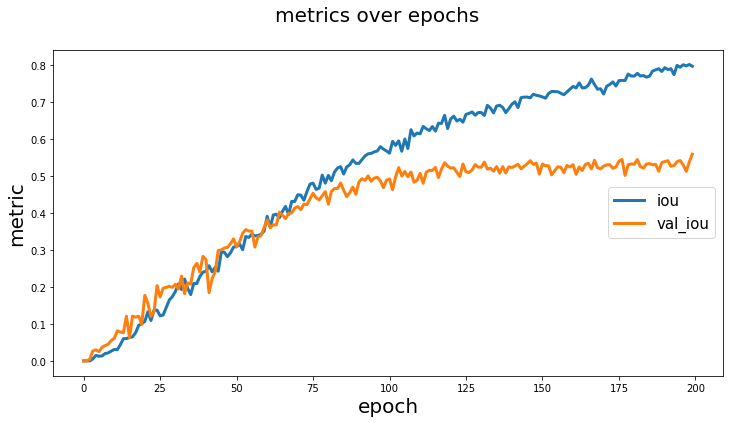

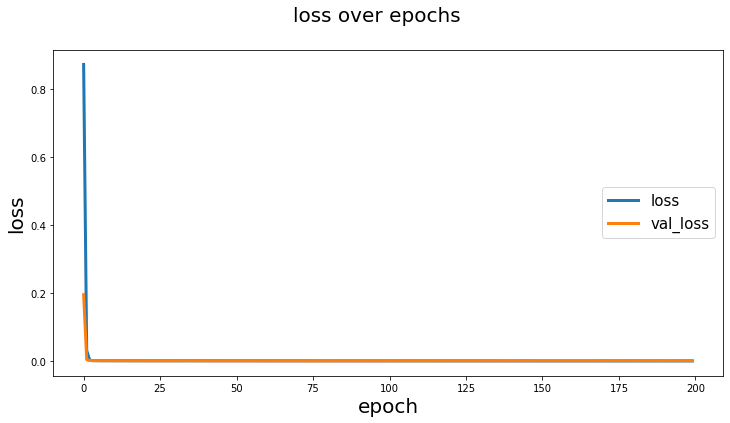

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

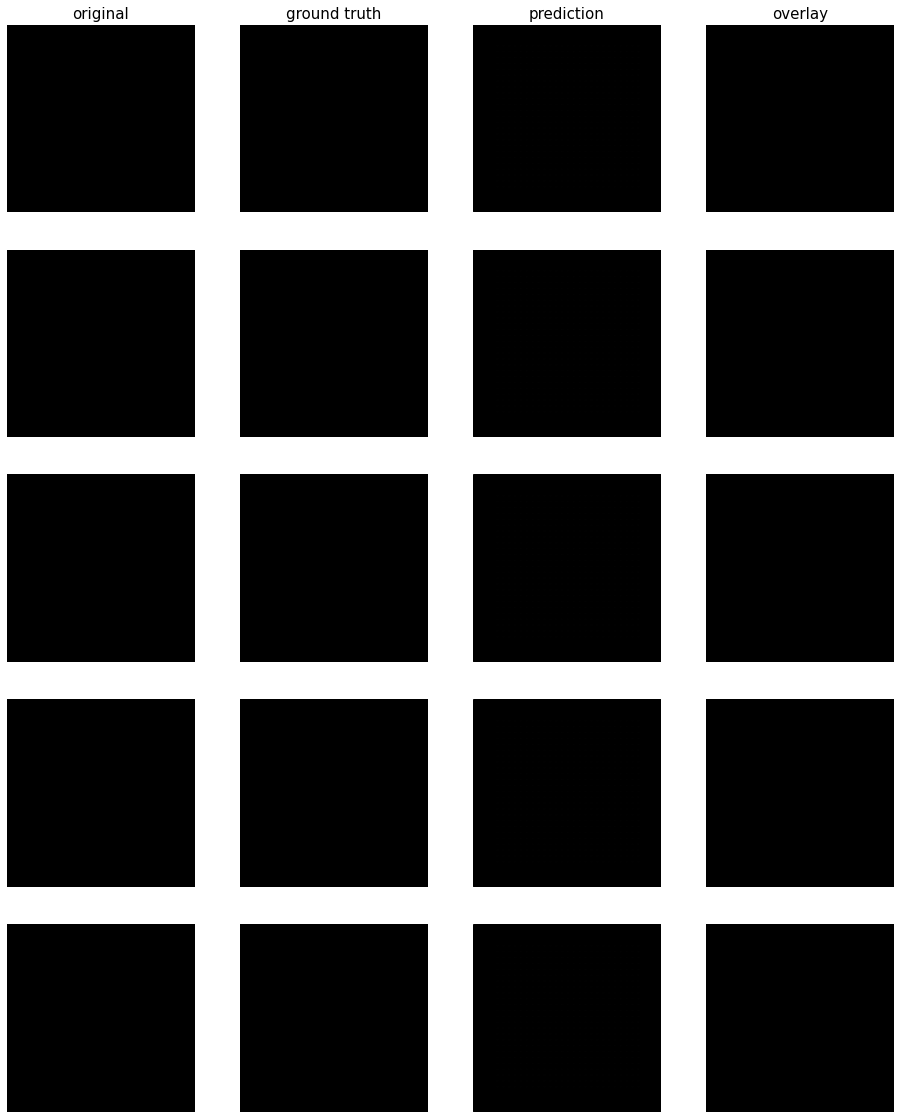

In [44]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [38]:
C.Helper.evaluate(test_images_array, y_test, model)

108/108 [==============================] - 24s 221ms/step - loss: 3.1781e-04 - iou: 0.1528 - iou_thresholded: 0.5383
